In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Read Excel file into DataFrame
data = pd.read_csv('March Madness.csv')

In [2]:
team_ratings = pd.read_csv('March Madness.csv')


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load datasets
team_stats = pd.read_csv('March Madness.csv')  # Team statistics
game_results = pd.read_csv('game_results.csv')  # Historical game results

# Merge datasets to prepare the training dataset
data = pd.merge(game_results, team_stats, left_on='team_1', right_on='Team')
data = pd.merge(data, team_stats, left_on='team_2', right_on='Team', suffixes=('_1', '_2'))

# Select features for training (you can adjust based on importance)
features = [
    'Rating_1', 'Rating_2',
    'PPG_1', 'PPG_2',
    'OPPG_1', 'OPPG_2',
    'TO/Game_1', 'TO/Game_2',
    '3 Pt. %_1', '3 Pt. %_2',
    'FT %_1', 'FT %_2',
    'Steals/Game_1', 'Steals/Game_2',
    'OREB/Game_1', 'OREB/Game_2',
    'SOS_1', 'SOS_2',
    'Pace of Play_1', 'Pace of Play_2',
    'NET Ranking_1', 'NET Ranking_2'
]

# Create the target variable (outcome: 1 if team_1 won, 0 otherwise)
X = data[features]
y = data['outcome']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")

# Function to predict a match
def predict_match(team_1, team_2, model):
    # Get stats for both teams
    team_1_stats = team_stats[team_stats['Team'] == team_1].iloc[0]
    team_2_stats = team_stats[team_stats['Team'] == team_2].iloc[0]
    
    # Create feature vector for prediction
    match_features = [
        team_1_stats['Rating'], team_2_stats['Rating'],
        team_1_stats['PPG'], team_2_stats['PPG'],
        team_1_stats['OPPG'], team_2_stats['OPPG'],
        team_1_stats['TO/Game'], team_2_stats['TO/Game'],
        team_1_stats['3 Pt. %'], team_2_stats['3 Pt. %'],
        team_1_stats['FT %'], team_2_stats['FT %'],
        team_1_stats['Steals/Game'], team_2_stats['Steals/Game'],
        team_1_stats['OREB/Game'], team_2_stats['OREB/Game'],
        team_1_stats['SOS'], team_2_stats['SOS'],
        team_1_stats['Pace of Play'], team_2_stats['Pace of Play'],
        team_1_stats['NET Ranking'], team_2_stats['NET Ranking']
    ]
    
    # Predict winner
    prediction = model.predict([match_features])[0]
    return team_1 if prediction == 1 else team_2

# Example match prediction
team1 = 'Alabama'
team2 = 'UConn'
winner = predict_match(team1, team2, models['Random Forest'])  # Choose the model you prefer
print(f"Predicted Winner: {winner}")


Logistic Regression Accuracy: 0.47
Random Forest Accuracy: 0.53
XGBoost Accuracy: 0.42
Predicted Winner: UConn


/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:16:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [2]:
# Train a basic Random Forest to check feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importance = pd.Series(model.feature_importances_, index=features)
importance = importance.sort_values(ascending=False)

# Print or visualize the most important features
print("Feature Importance:")
print(importance)

# Optional: Select only the top N features (e.g., top 10)
top_features = importance.head(10).index.tolist()
X_train_refined = X_train[top_features]
X_test_refined = X_test[top_features]


Feature Importance:
NET Ranking_2     0.152435
SOS_2             0.081375
Rating_2          0.074688
Pace of Play_2    0.057725
NET Ranking_1     0.055477
PPG_2             0.054999
3 Pt. %_2         0.044832
Steals/Game_1     0.044480
3 Pt. %_1         0.043204
OREB/Game_1       0.042888
OPPG_1            0.041816
SOS_1             0.041084
FT %_2            0.040304
Pace of Play_1    0.039504
PPG_1             0.036473
Steals/Game_2     0.034346
OPPG_2            0.029559
TO/Game_1         0.023650
FT %_1            0.016562
Rating_1          0.015826
OREB/Game_2       0.014684
TO/Game_2         0.014088
dtype: float64


In [3]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train the model using refined features
model = RandomForestClassifier(random_state=42)
model.fit(X_train_refined, y_train)

# Make predictions
y_pred = model.predict(X_test_refined)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
y_prob = model.predict_proba(X_test_refined)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Cross-validation accuracy
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.50      0.40      0.44        10

    accuracy                           0.47        19
   macro avg       0.48      0.48      0.47        19
weighted avg       0.48      0.47      0.47        19

ROC-AUC Score: 0.57
Cross-Validation Accuracy: 0.63 ± 0.16


In [4]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Grid Search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_refined, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Use the best model for final predictions
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_refined)
final_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Final Test Accuracy with Tuned Model: {final_accuracy:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.80
Final Test Accuracy with Tuned Model: 0.58


/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [5]:
top_features = [
    'NET Ranking_2', 'SOS_2', 'Rating_2', 'Pace of Play_2', 
    'NET Ranking_1', 'PPG_2', '3 Pt. %_2', 'Steals/Game_1', 
    '3 Pt. %_1', 'OREB/Game_1'
]

# Subset the data to include only top features
X_train_refined = X_train[top_features]
X_test_refined = X_test[top_features]
# Train Random Forest with refined features
model = RandomForestClassifier(random_state=42)
model.fit(X_train_refined, y_train)

# Evaluate performance
y_pred = model.predict(X_test_refined)
print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_refined)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.50      0.40      0.44        10

    accuracy                           0.47        19
   macro avg       0.48      0.48      0.47        19
weighted avg       0.48      0.47      0.47        19

ROC-AUC Score: 0.57


In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_refined, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate best model on test set
y_pred_best = best_model.predict(X_test_refined)
final_accuracy = accuracy_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_refined)[:, 1])

print(f"Final Test Accuracy: {final_accuracy:.2f}")
print(f"Final Test ROC-AUC: {roc_auc:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Final Test Accuracy: 0.53
Final Test ROC-AUC: 0.60


Updated Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13

Updated Feature Importance:
PPG_2                   0.118819
NET Ranking_2           0.117491
SOS_2                   0.097551
NET_Diff                0.095690
SOS_Diff                0.076809
PPG_Diff                0.073676
Rating_2                0.068571
Aggressive_Play_Diff    0.066158
Rating_Diff             0.063244
FT_Ratio                0.047410
3PT_Ratio               0.046727
NET Ranking_1           0.046122
3 Pt. %_2               0.041040
Pace_Ratio              0.040692
dtype: float64


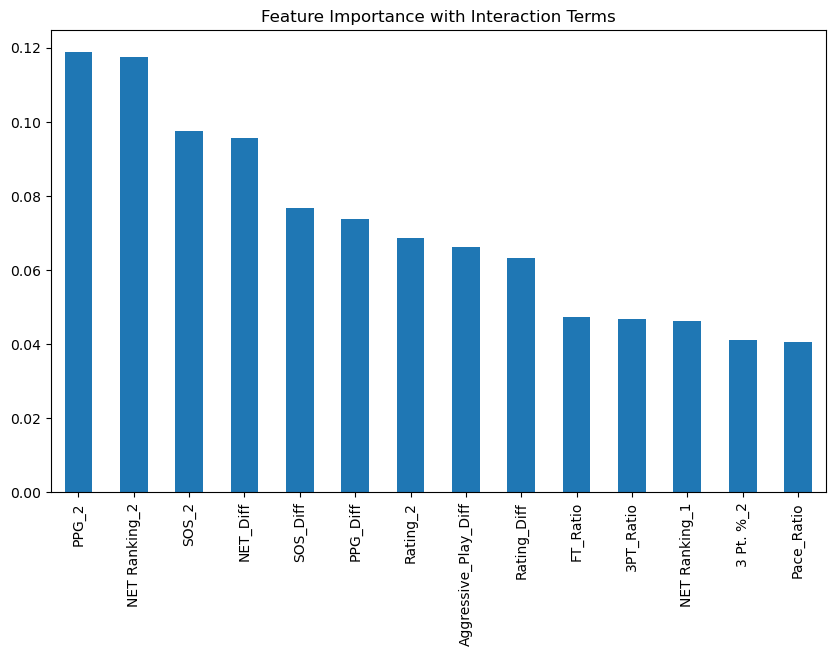

In [7]:
# Add interaction terms
data['NET_Diff'] = data['NET Ranking_1'] - data['NET Ranking_2']
data['Rating_Diff'] = data['Rating_1'] - data['Rating_2']
data['PPG_Diff'] = data['PPG_1'] - data['PPG_2']
data['SOS_Diff'] = data['SOS_1'] - data['SOS_2']

data['FT_Ratio'] = data['FT %_1'] / (data['FT %_2'] + 1e-5)  # Avoid division by zero
data['3PT_Ratio'] = data['3 Pt. %_1'] / (data['3 Pt. %_2'] + 1e-5)
data['Pace_Ratio'] = data['Pace of Play_1'] / (data['Pace of Play_2'] + 1e-5)

data['Aggressive_Play_1'] = data['Steals/Game_1'] + data['OREB/Game_1']
data['Aggressive_Play_2'] = data['Steals/Game_2'] + data['OREB/Game_2']
data['Aggressive_Play_Diff'] = data['Aggressive_Play_1'] - data['Aggressive_Play_2']

# Subset features for model
features = [
    'NET_Diff', 'Rating_Diff', 'PPG_Diff', 'SOS_Diff',
    'FT_Ratio', '3PT_Ratio', 'Pace_Ratio',
    'Aggressive_Play_Diff',
    'NET Ranking_2', 'Rating_2', 'SOS_2',  # Include key original features
    'NET Ranking_1', 'PPG_2', '3 Pt. %_2'
]

X = data[features]
y = data['outcome']

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the updated model
y_pred = model.predict(X_test)
print("Updated Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance visualization
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("Updated Feature Importance:")
print(importances)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importance with Interaction Terms')
plt.show()


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=aut

/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Hyperparameters found:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy of the best model:  0.7692307692307693
Feature Importance of Best Model:
PPG_2                   0.143522
NET Ranking_2           0.139457
SOS_2                   0.129283
NET_Diff                0.096103
Rating_2                0.077275
SOS_Diff                0.067548
Rating_Diff             0.062997
NET Ranking_1           0.052295
Aggressive_Play_Diff    0.051363
PPG_Diff                0.045277
3 Pt. %_2               0.042382
FT_Ratio                0.032508
3PT_Ratio               0.032457
Pace_Ratio              0.027534
dtype: float64


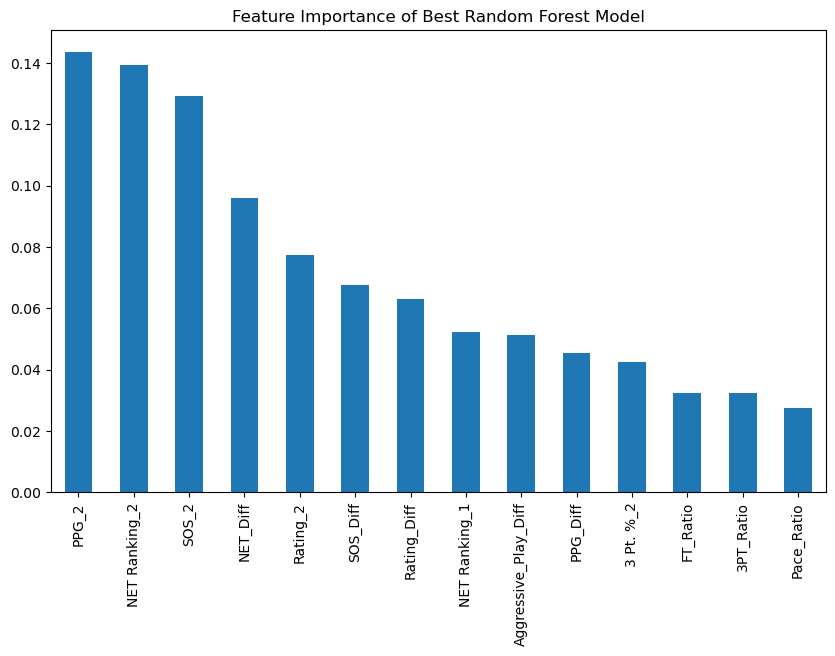

In [8]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider for splitting at each node
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters found: ", best_params)

# Train the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_rf_model.predict(X_test)
print("Accuracy of the best model: ", accuracy_score(y_test, y_pred_best))

# Display feature importance of the best model
importances_best = pd.Series(best_rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importance of Best Model:")
print(importances_best)

# Plot feature importance
plt.figure(figsize=(10, 6))
importances_best.plot(kind='bar')
plt.title('Feature Importance of Best Random Forest Model')
plt.show()


Accuracy of the Random Forest model with selected features:  0.5384615384615384
Feature Importance of the Random Forest Model with Selected Features:
PPG_2                   0.156195
NET Ranking_2           0.153360
SOS_Diff                0.087662
NET_Diff                0.084808
SOS_2                   0.076858
PPG_Diff                0.066189
NET Ranking_1           0.058090
Aggressive_Play_Diff    0.053808
3 Pt. %_2               0.052654
3PT_Ratio               0.052404
Rating_Diff             0.049902
Rating_2                0.044965
Pace_Ratio              0.037999
FT_Ratio                0.025105
dtype: float64


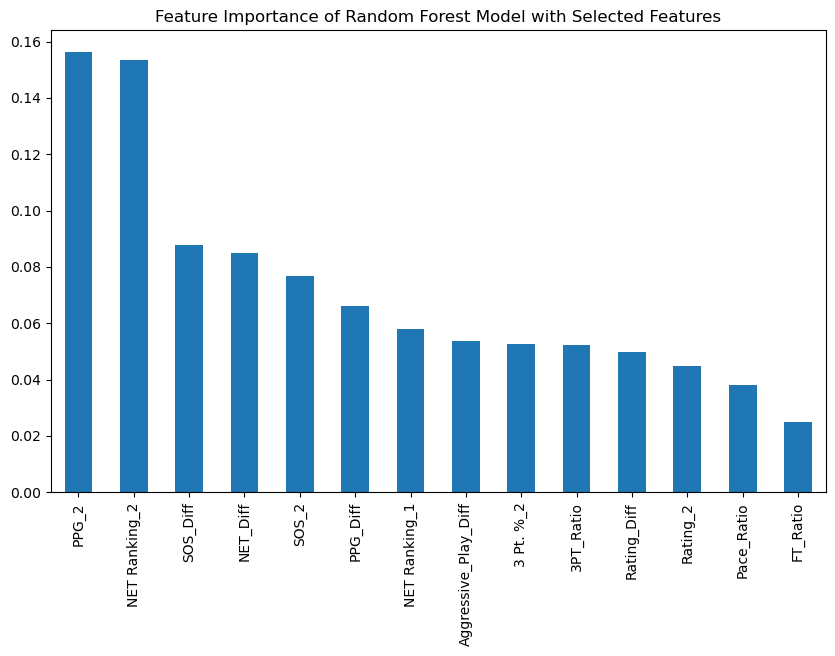

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=l

In [9]:
# Select the top important features based on feature importance
top_features = [
    'PPG_2', 'NET Ranking_2', 'SOS_2', 'NET_Diff', 'SOS_Diff', 
    'PPG_Diff', 'Rating_2', 'Aggressive_Play_Diff', 'Rating_Diff', 
    'FT_Ratio', '3PT_Ratio', 'NET Ranking_1', '3 Pt. %_2', 'Pace_Ratio'
]

# Subset the data to only include these important features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Initialize and train the Random Forest model with selected features
rf_model_top = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=5)

# Train the model
rf_model_top.fit(X_train_top, y_train)

# Predict on the test set
y_pred_top = rf_model_top.predict(X_test_top)

# Evaluate the accuracy
accuracy_top = accuracy_score(y_test, y_pred_top)
print("Accuracy of the Random Forest model with selected features: ", accuracy_top)

# Display feature importance of the selected model
importances_top = pd.Series(rf_model_top.feature_importances_, index=top_features).sort_values(ascending=False)
print("Feature Importance of the Random Forest Model with Selected Features:")
print(importances_top)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
importances_top.plot(kind='bar')
plt.title('Feature Importance of Random Forest Model with Selected Features')
plt.show()
